# Efficient Compressed Sensing SENSE pMRI Reconstruction With Joint Sparsity Promotion
Il Yong Chun, Ben Adcock, and Thomas M. Talavage, 2015

## Julia Implementation

In [1]:
using LinearAlgebra, MAT, FFTW, Wavelets, Random, Plots, PyPlot

In [2]:
using SparseArrays

In [3]:
using Distributions 

In [4]:
using Images

### Initialisation

In [623]:
# Load data 
file = matopen("data/brain_coil.mat");
coilScans = read(file, "brain_coil_tmp");
close(file);
file = matopen("data/coil_sensitivity_map.mat");
coilSensitivityMaps = read(file, "coil_map");
close(file);

# # K-spaces
# cs = zeros(64,64,5)
# for i = 1:5
#     cs[:,:,i] =  imresize(coilScans[:,:,i], (64, 64));
# end
# coilScans = cs;
# sm = zeros(64,64,5)
# for i = 1:5
#     sm[:,:,i] =  imresize(coilSensitivityMaps[:,:,i], (64, 64));
# end
# coilSensitivityMaps = sm;
height, width, C = size(coilScans);
N = height*width; # Length of vectorised images

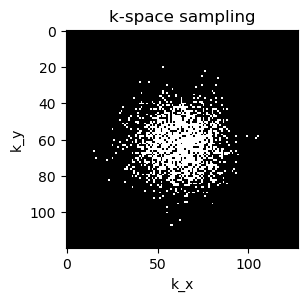

In [701]:

# Simulate k-space sampling
# Here we sample in Gaussian distributed fashion
lb = 1    # The truncation lower bound
ub = height    # The truncation upper bound
mu = trunc(Int32, min(height,width)/2+abs(height-width)/2)    # The mean of the truncated Normal
sigma = 12 # The standard deviation of the truncated Normal
d = Truncated(Normal(mu, sigma), lb, ub)  #Construct the distribution type

samp = 2000 # Number of samples
ind = trunc.(Int64, rand(d, samp,2)); # Indices of samples (possibly duplicated coordinates here)

A = zeros(height,width)
for i = 1: samp
    A[ind[i,1],ind[i,2]] = Int(1)
end
# A = A.==1 # Turn into logical matrix
# A = circshift(A, trunc(Int32, height/2))
# A = circshift(A', trunc(Int32, width/2))'

# ind = findall(x->x==true, A); # Find indices of entries in A where the entry is not 0, now indices are unique



figure(figsize=(3,3))
imshow(A, cmap = "gray")
xlabel("k_x")
ylabel("k_y")
title("k-space sampling");

P_Omega = A;

### Utility functions 

In [702]:
# height = 3;
# width = 3;
# C = 2;
# x = rand(height,width,C)  # Example for verification purposes
# P_Omega = ones(height, width)

In [717]:
# Operators, Notation as in Paper
function SoS(x)
    x = sum(abs.(x).^2, dims = 3)
    return sqrt.(x)
end

function Jsoftshrink(x, lambda)
   return (x./norm(x)) .* max(norm(x) - lambda, 0)
end

function Psi(x)
    return dwt(x, wavelet(WT.db4));
end
function Psi_H(x)
    return idwt(x, wavelet(WT.db4));
end
function Phi(x)
    return fftshift(fft(x));
end
function Phi_H(x)
    return ifft(ifftshift(x));
end
function Phi_c(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = Phi(x[:,:,i]);
    end
    return y
end
function Phi_cH(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = Phi_H(x[:,:,i]);
    end
    return y
end
function Psi_c(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = Psi(x[:,:,i]);
    end
    return y
end
function Psi_cH(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = Psi_H(x[:,:,i]);
    end
    return y
end
function F_Omega_c(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = P_Omega.*Phi(x[:,:,i]);
    end
    return y
end
function F_Omega_cH(x)
    y = zeros(height,width,C).+0*im
    for i = 1:C
        y[:,:,i] = Phi_H(P_Omega.*x[:,:,i]);
    end
    return y
end;
# norm(Phi_c(Phi_cH(x)) - x)
# norm(Psi_c(Psi_cH(x)) - x)
# norm(F_Omega_c(F_Omega_cH(x)) - x)

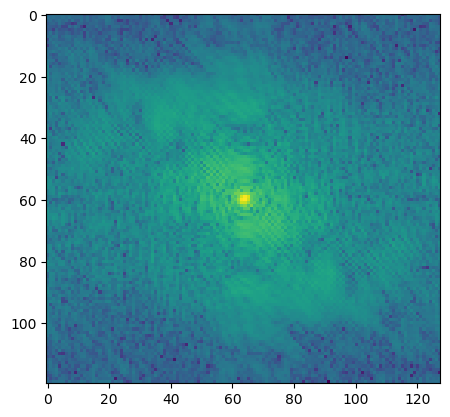

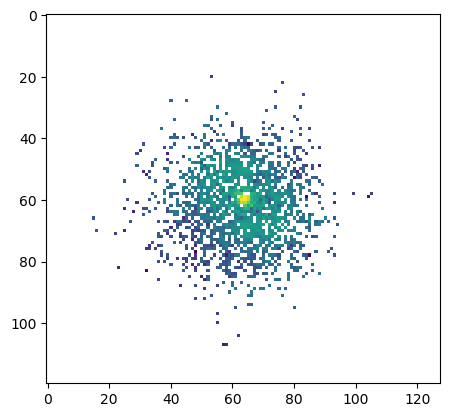

In [753]:
# Simulate K-Space data
y_original = Phi(coilScans); # Full K-Space data of vectorised coil images


y_data = P_Omega.*(y_original + 1*randn(height, width, C)); # Added some noise
PyPlot.imshow(log.(abs.(y_original[:,:,2])))
figure()
PyPlot.imshow(log.(abs.(y_data[:,:,2])))
# y_data = y_data[:] + randn(C*N); # Added some noise

S = coilSensitivityMaps;

In [720]:
# Define operator inv(S^H S) S^H
inv_SHS = 1 ./sum(S.^2, dims = 3);
inv_SHS_SH = inv_SHS .* S
function apply_inv_SHS_SH(x)
    return sum(inv_SHS_SH.*x, dims = 3);
end;
# function apply_inv_SHS_SH(x)
#     return inv_SHS_SH.*x;
# end;

In [704]:
# Define hyperparameters 
α = 0.05;
β = 0.1;
ν = 0.1;
nInner = 1; # Number of inner Bregman iterations 
nOuter = 4; # Number of outer Bregman iterations 
# delta = # Alternatively can define threshold for stopping condition instead of nOuter

In [721]:
# Precompute Lambda
inv_Lambda = 1 ./(α*P_Omega.^2 .+ (β + v))
# Define Operator inv(Lambda)
function apply_invLambda(x)
     return inv_Lambda.*x;
end

apply_invLambda (generic function with 1 method)

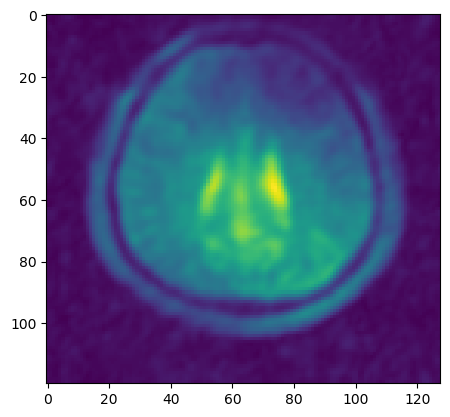

In [723]:
# Initialise values  
y = y_data;
x = SoS(Phi_cH(y));
imshow(abs.(x[:,:,1]))

# ds = rand(height,width,C);
# dpsi = rand(height,width,C);
# bs = rand(height,width,C);
# bpsi = rand(height,width,C);
ds = zeros(height,width,C);
dpsi = ds;
bs = ds;
bpsi = ds;
Sx = S.*x;

### SENSE pMRI reconstruction with JS, without the total variation regularization

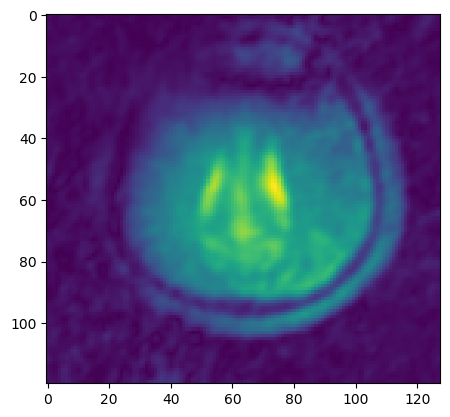

||y-y_data|| = 6.204745228845832e7

In [724]:
for nOut = 1:nOuter
    for nIn = 1:nInner
        x = apply_inv_SHS_SH(ds - bs); # SOS init will get canceled here
        ds = Phi_cH(apply_invLambda(Phi_c(α*F_Omega_cH(y) + β*Psi_cH(dpsi-bpsi) + ν*(S.*x+bs))));
        dpsi = Jsoftshrink(Psi_c(ds) + bpsi, 1/β);
        bs = bs + Sx - ds;
        bpsi = bpsi + Psi_c(ds) - dpsi;
    end
    y = y + y_data - F_Omega_c(S.*x);
end

print("||y-y_data|| = ",norm(y-y_data))

PyPlot.imshow(SoS(x)[:,:,1]);